In [1]:
import nvidia
import nvidia.cudnn
print(nvidia.cudnn.__file__)

/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/nvidia/cudnn/__init__.py


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2024-05-02 13:58:13.420584: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 13:58:13.447097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 13:58:13.875820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-02 13:58:14.291353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 13:58:14.310438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 13:58:14.310589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from typing import List
from matplotlib import pyplot as plt
import numpy as np

from importlib import reload
import pisces.models as pm

from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
import matplotlib.pyplot as plt

from pisces.data_sets import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

In [4]:

mo = pm.MOResUNetPretrained(sampling_hz=32)


In [5]:
from sklearn.metrics import auc as area
def roc_for_class(X, y, neg_class: int):
    pr = mo.predict_probabilities(X)[0]
    p_not_class = 1 - pr[:, neg_class]
    y_padded = np.zeros_like(p_not_class)
    mask = np.zeros_like(p_not_class)
    # just score the class
    y_padded[:y.shape[0]] = y != neg_class
    # PSG with negative value indicates to ignore that epoch
    mask[:y.shape[0]] = y >= 0
    
    return pm.roc_curve(y_padded, p_not_class, sample_weight=mask)

class_names = ['Wake', 'Light', 'Deep', 'REM']
def accuracy_for_class(X, y, mo_net: pm.MOResUNetPretrained, class_: int | None = None, class_name: str | None = None):
    if class_ is None:
        class_ = class_names.index(class_name)
    
    pr = mo_net.predict_probabilities(X)[0]
    # mask = np.zeros_like(p_not_class)
    max_likelihood = pr.argmax(axis=1)
    y_padded = np.zeros_like(max_likelihood)
    y_padded[:y.shape[0]] = y
    mask = np.zeros_like(max_likelihood)
    # PSG with negative value indicates to ignore that epoch
    mask[:y.shape[0]] = y >= 0

    # total matches for class / total examples

    return np.sum((max_likelihood == y_padded) & (y_padded == class_) & mask) / max(np.sum(y == class_), 1)


# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [6]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
evaluations_walch, mo_preprocessed_data_walch = mo.evaluate_data_set(walch)
mo_aucs_walch = [e["auc"] for e in evaluations_walch.values()]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch.values()]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch.values()]


Using 12 of 12 cores (100%) for parallel preprocessing.
This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)


getting needed X, y for 1066528getting needed X, y for 1360686getting needed X, y for 1449548getting needed X, y for 1455390getting needed X, y for 1818471getting needed X, y for 2598705getting needed X, y for 2638030getting needed X, y for 3509524getting needed X, y for 4018081getting needed X, y for 4426783
getting needed X, y for 3997827



getting needed X, y for 4314139






sampling hz:sampling hz: 32
 32masking

maskingsampling hz:
sampling hz:  3232

masking
Masked 1 PSG epochssampling hz:
Masked 1 PSG epochsmasking
 
sampling hz:32 32
sampling hz:sampling hz:
masking  masking
Masked 1 PSG epochs

sampling hz: resampling to 32Hz (0.03125s) from 66 Hz (0.01502s)32sampling hz:sampling hz:sampling hz:
32
32 masking 32 resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)



32masking32masking
maskingresampling to 32Hz (0.03125s) from 66 Hz (0.01501s)



maskingMasked 1 PSG epochs



masking
Masked 2 PSG epochsMasked 1 PSG epochsMasked 1 PSG epochs
Masked 1 PSG epochsMasked 1 PSG ep

In [7]:
X_0, y_0 = mo_preprocessed_data_walch[0][0]

fpr_pre, tpr_pre, thr_pre = roc_for_class(X_0, y_0, 0)

2024-05-02 13:58:45.113731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 13:58:45.113870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 13:58:45.113948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1714676328.449418  614523 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
def accuracy_summary(X_0, y_0, mo_net) -> List[float]:
    class_accuracies = []
    for class_no in range(4):
        class_accuracies.append(
            accuracy_for_class(X_0, y_0, mo_net, class_no))
    for class_no in range(4):
        print(f"Accuracy for {class_names[class_no]} is\t{class_accuracies[class_no]:.3f}")
    return class_accuracies

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


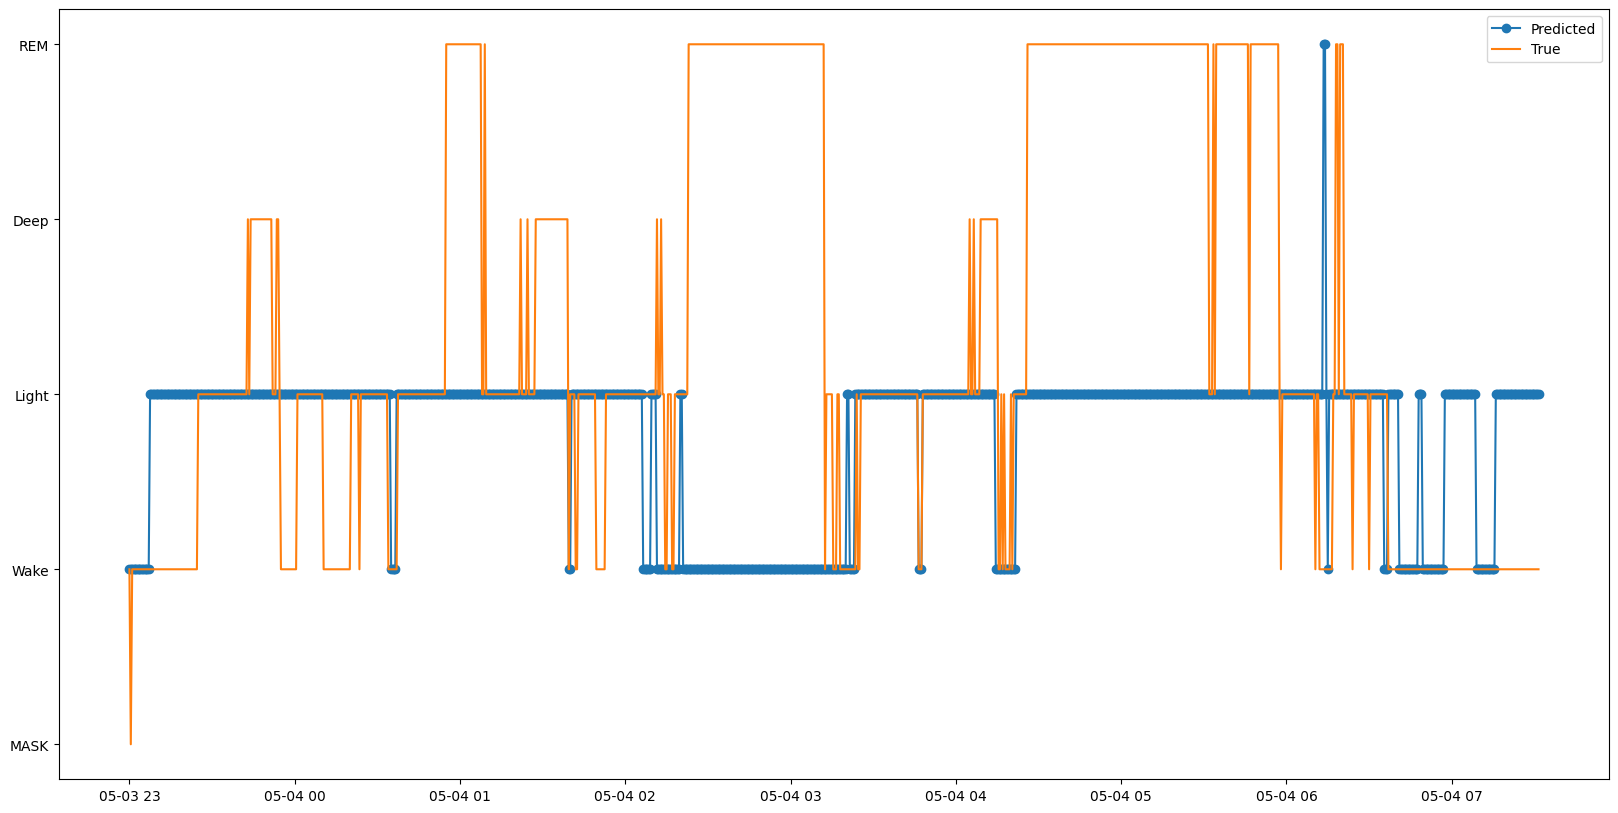

In [9]:
pr_hat = mo.predict_probabilities(X_0)[0]
y_0_hat = np.argmax(pr_hat, axis=1)
y_0_pad = np.zeros_like(y_0_hat)
y_0_pad[:y_0.shape[0]] = y_0

plt.figure(figsize=(20, 10))

# make a numpy datetime array starting at May 3, 2024 and having one entry every 30 seconds for len(y_0_pad) entries
# this is just for the x-axis
from datetime import datetime, timedelta

dt = datetime(2024, 5, 3, 23)
x_time = np.array([dt + timedelta(seconds=30 * i) for i in range(len(y_0_pad))])

# PSG with negative value indicates to ignore that epoch
plt.plot(x_time, y_0_hat, "o-")
plt.plot(x_time, y_0_pad)#, "o-")

y_labels =[
    "MASK",
    *class_names
    # "Wake",a
    # "Light",
    # "Deep",
    # "REM"
]



plt.yticks([r - 1 for r in range(len(y_labels))], y_labels)

plt.legend(["Predicted", "True"])

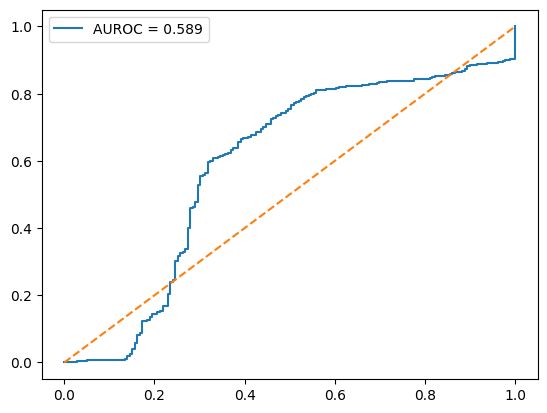

In [10]:
plt.plot(fpr_pre, tpr_pre, label=f"AUROC = {area(fpr_pre, tpr_pre):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()

In [11]:
x = np.array([[1.0, 2, 3]])
print(x)
print(
    np.pad(
        x,
        pad_width=[
            (2, 1),
            (0, 3),
        ]
    )
)

[[1. 2. 3.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 2. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [12]:
from sklearn.model_selection import LeaveOneOut


reload(pm)

trained_mos = []
evaluated_test_sets = []

break_up_line = "=" * 20

# instantiate BEFORE loop, we set on the end of loop, see comments below
mo_pre = pm.MOResUNetPretrained()
for train, test in LeaveOneOut().split(range(len(mo_preprocessed_data_walch))):
    print(f"\n\n{break_up_line}\nTest index {test}, subject {walch.ids[test[0]]}")

    mo_run = pm.run_split(
        train_indices=train,
        preprocessed_data_set=mo_preprocessed_data_walch,
        swc=mo_pre,
        epochs=20
    )

    # instantiate AFTER training to get a fresh one to evaluate
    mo_pre = pm.MOResUNetPretrained()
    print("PRE-TRAINING")
    X_test, y_test = mo_preprocessed_data_walch[test[0]][0]
    accuracy_summary(X_test, y_test, mo_pre)
    print(break_up_line)

    print("POST-TRAINING")
    # y_prob = mo_run.predict_probabilities(mo_preprocessed_data_walch[test[0]][0][0])[0]
    accuracy_summary(X_test, y_test, mo_run)

    trained_mos.append(mo_run)



Test index [0], subject 1066528
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - loss: 1.7769 - val_loss: 0.9336
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.6282 - val_loss: 0.8982
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.7783 - val_loss: 0.8973
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.4841 - val_loss: 0.8957
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2464 - val_loss: 0.8794
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2183 - val_loss: 0.8680
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2625 - val_loss: 0.8747
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2199 - val_loss: 0.8837
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.1720 - val_loss: 0.8997
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.3943 - val_loss: 0.9197
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2754 - val_loss: 0.9409
Epoch 12/20
27/27 ━━━━━━━━━

In [13]:
len(mo_preprocessed_data_walch)

31

In [14]:
len(trained_mos)

31

In [15]:
import polars as pl 

pre_accuracies = []
accuracies = []
for index, ((X, y), id) in enumerate(mo_preprocessed_data_walch):
    pre_accuracies.append(accuracy_summary(X, y, pm.MOResUNetPretrained()))
    accuracies.append(accuracy_summary(X, y, trained_mos[index]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy for Wake is	0.391
Accuracy for Light is	0.907
Accuracy for Deep is	0.000
Accuracy for REM is	0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy for Wake is	0.363
Accuracy for Light is	0.619
Accuracy for Deep is	0.548
Accuracy for REM is	0.324
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy for Wake is	0.205
Accuracy for Light is	0.939
Accuracy for Deep is	0.000
Accuracy for REM is	0.014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy for Wake is	0.325
Accuracy for Light is	0.602
Accuracy for Deep

In [16]:
# organize per-column by zipping these all together
accuracies = list(zip(*accuracies))
acc_df = pl.DataFrame({class_names[j]: accuracies[j] for j in range(len(class_names))})

pre_accuracies = list(zip(*pre_accuracies))
pre_acc_df = pl.DataFrame({class_names[j]: pre_accuracies[j] for j in range(len(class_names))})

1. CSVs per subject of epoch_timestamp,y_true,y_pred
2. CSV of accuracies per subject
3. Nice representative hypnogram

In [17]:
acc_df.head()

Wake,Light,Deep,REM
f64,f64,f64,f64
0.363128,0.618687,0.548387,0.323625
0.324786,0.602174,0.276074,0.182692
0.269231,0.559783,0.986111,0.357143
0.345238,0.506512,0.0,0.6
1.0,0.614334,0.0,0.345455


In [18]:
acc_df.describe()

statistic,Wake,Light,Deep,REM
str,f64,f64,f64,f64
"""count""",31.0,31.0,31.0,31.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.542343,0.643722,0.628583,0.411467
"""std""",0.256487,0.160966,0.289559,0.250663
"""min""",0.16092,0.254237,0.0,0.0
"""25%""",0.327273,0.582505,0.478261,0.211604
"""50%""",0.551282,0.65,0.675159,0.421687
"""75%""",0.753623,0.765199,0.894737,0.6
"""max""",1.0,0.870968,1.0,0.885714


In [19]:
pre_acc_df.describe()

statistic,Wake,Light,Deep,REM
str,f64,f64,f64,f64
"""count""",31.0,31.0,31.0,31.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.518169,0.912932,0.07633,0.037175
"""std""",0.255994,0.10417,0.186324,0.071613
"""min""",0.075949,0.538606,0.0,0.0
"""25%""",0.34375,0.874396,0.0,0.0
"""50%""",0.528846,0.97491,0.005525,0.003311
"""75%""",0.724138,0.991379,0.070175,0.034188
"""max""",0.981308,1.0,1.0,0.324561


In [20]:
acc_df.write_csv("finetuned-mo-walch-acc.csv")

In [21]:
acc_df.describe().write_csv("finetuned-mo-walch-acc-stats.csv")

In [22]:
acc_np = acc_df.to_numpy()

In [25]:
np.argmax(np.sum(acc_np, axis=1))

9

In [28]:
acc_np[9]

array([0.83544304, 0.80676329, 0.75141243, 0.88571429])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Text(0.5, 1.0, 'Subject 4018081')

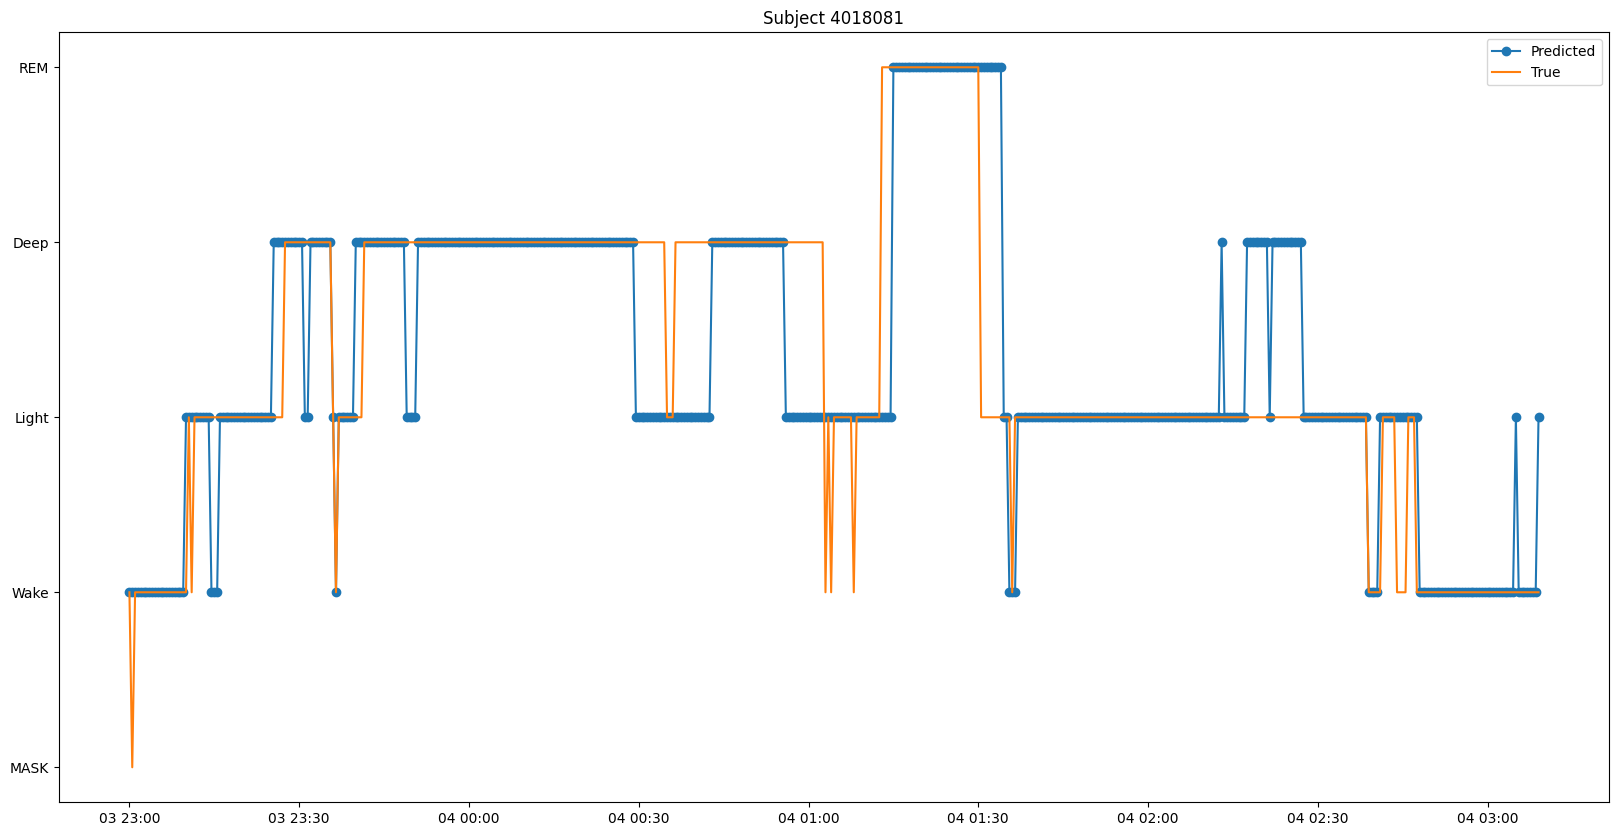

In [31]:
index = 9
X, y = mo_preprocessed_data_walch[index][0]
pr_hat = trained_mos[index].predict_probabilities(X)[0]
pr_trim = pr_hat[:y.shape[0]] # trim to the length of the actual PSG; padded for deeply connected layer reasons
y_hat = np.argmax(pr_trim, axis=1)
y_pad = y # don't change y; leaving in variable for ease of refactoring this example.

plt.figure(figsize=(20, 10))

# make a numpy datetime array starting at May 3, 2024 and having one entry every 30 seconds for len(y_pad) entries
# this is just for the x-axis
from datetime import datetime, timedelta

dt = datetime(2024, 5, 3, 23)
x_time = np.array([dt + timedelta(seconds=30 * i) for i in range(len(y_pad))])

# PSG with negative value indicates to ignore that epoch
plt.plot(x_time, y_hat, "o-")
plt.plot(x_time, y_pad)#, "o-")

y_labels =[
    "MASK",
    *class_names
]



plt.yticks([r - 1 for r in range(len(y_labels))], y_labels)

plt.legend(["Predicted", "True"])
plt.title(f"Subject {mo_preprocessed_data_walch[index][1]}")

In [43]:
def plot_hypno(index: int):
    X, y = mo_preprocessed_data_walch[index][0]
    pr_hat = trained_mos[index].predict_probabilities(X)[0]
    pr_trim = pr_hat[:y.shape[0]] # trim to the length of the actual PSG; padded for deeply connected layer reasons
    y_hat = np.argmax(pr_trim, axis=1)
    y_pad = y # don't change y; leaving in variable for ease of refactoring this example.

    plt.figure(figsize=(20, 10))

    # make a numpy datetime array starting at May 3, 2024 and having one entry every 30 seconds for len(y_pad) entries
    # this is just for the x-axis
    from datetime import datetime, timedelta

    dt = datetime(2024, 5, 3, 23)
    x_time = np.array([dt + timedelta(seconds=30 * i) for i in range(len(y_pad))])

    # PSG with negative value indicates to ignore that epoch
    plt.plot(x_time, y_hat, "o-")
    plt.plot(x_time, y_pad)#, "o-")

    y_labels =[
        "MASK",
        *class_names
    ]



    plt.yticks([r - 1 for r in range(len(y_labels))], y_labels)

    plt.legend(["Predicted", "True"])
    plt.title(f"Subject {mo_preprocessed_data_walch[index][1]}")

In [76]:
# acc_cut = np.concatenate([acc_np[:19, :], acc_np[20:, :]])
acc_cut = acc_np
avg = np.mean(acc_cut, axis=0)
acc_np_vs_avg = np.abs(acc_cut - avg)
most_avg_index = np.argmin(np.linalg.norm(acc_np_vs_avg, axis=1))

In [77]:
most_avg_index

20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


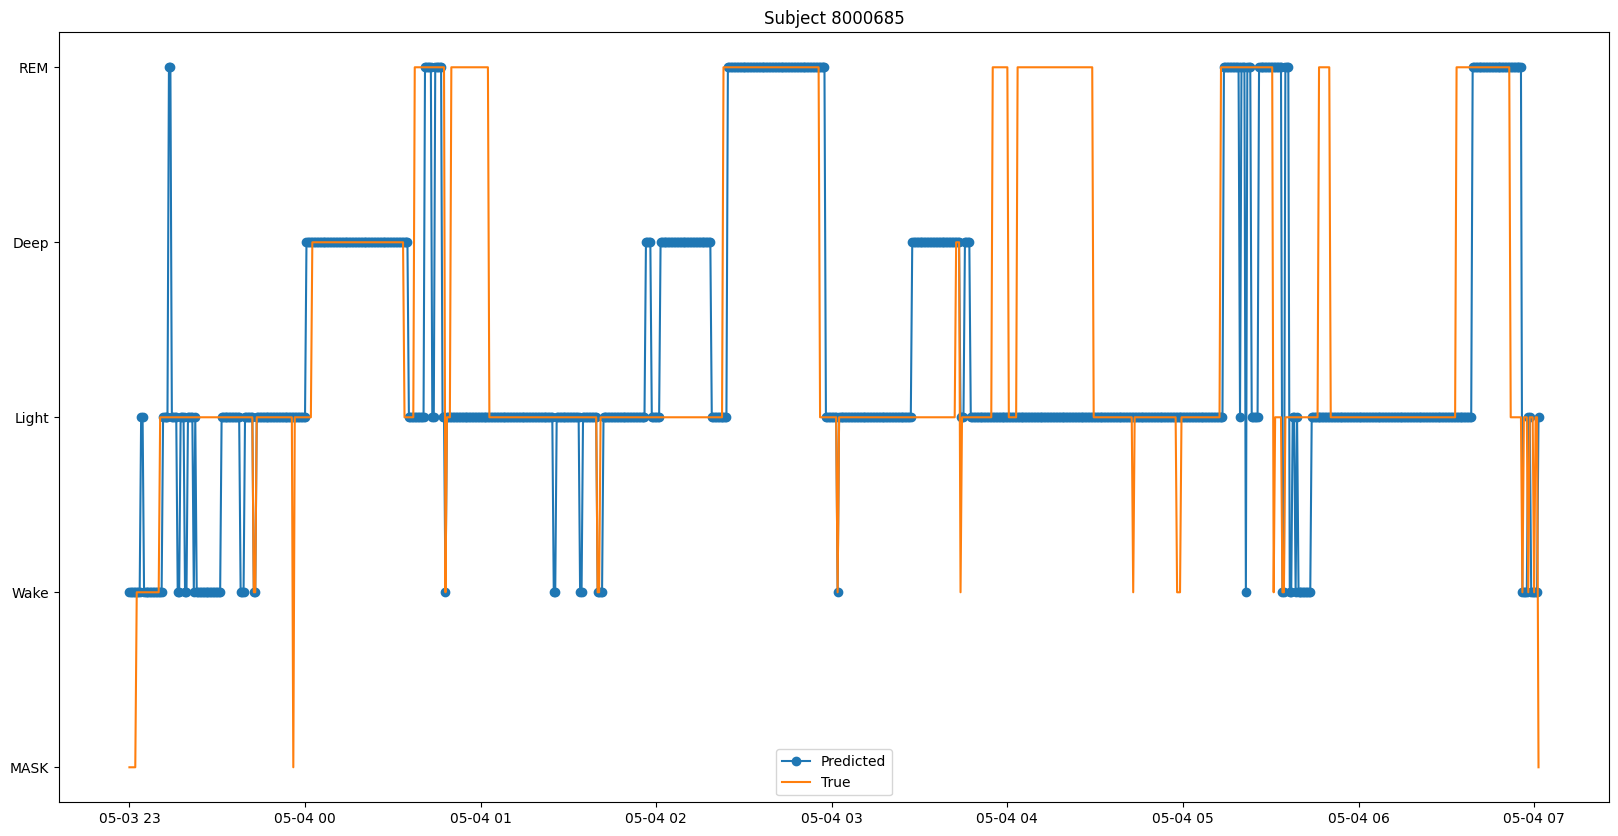

In [78]:
plot_hypno(most_avg_index+1)

In [63]:
np.sum(avg)

2.2639930781933564

In [68]:
acc_np_vs_avg.shape

(30, 4)

In [70]:
per_class_avgs = np.linalg.norm(acc_np_vs_avg, axis=1).reshape(-1, 1)

In [71]:
per_class_avgs.shape

(31, 1)

In [82]:
results_index = []
id_rows = []
y_true = []
y_pred_max_lk = []

for j, ((X, y), id) in enumerate(mo_preprocessed_data_walch):
    pr_hat = trained_mos[j].predict_probabilities(X)[0]
    pr_trim = pr_hat[:y.shape[0]] # trim to the length of the actual PSG; padded for deeply connected layer reasons
    y_hat = np.argmax(pr_trim, axis=1)
    y_pad = y # don't change y; leaving in variable for ease of refactoring this example.

    id_rows.extend([id] * len(y_hat))
    results_index.extend([j] * len(y_hat))
    y_true.extend(y_pad)
    y_pred_max_lk.extend(y_hat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [83]:
all_preds_df = pl.DataFrame({
    "results_index": results_index,
    "id": id_rows,
    "y_true": y_true,
    "y_pred": y_pred_max_lk
}) 

In [84]:
all_preds_df.write_csv("finetuned-mo-walch-predictions.csv")